## **Imports**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive
from tqdm.auto import tqdm
from glob import glob
import requests
import cv2
import os

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


## **CUB-200-2011 Dataset**

When attempting to download the CUB-200-2011 dataset, also known as Caltech Birds 2011, via TensorFlow Datasets, a `NonMatchingChecksumError` occurs, likely due to issues with Google Drive, where the dataset is hosted. To resolve this, the dataset is manually downloaded from the official [Caltech Vision Lab](https://www.vision.caltech.edu/datasets/cub_200_2011/) website. The images, labels, bounding boxes and segmentation masks are correctly organized and prepared using the Pandas and Pillow libraries, making them ready for direct use in training or fine-tuning a computer vision model. Finally, the dataset is compressed into a zip file and saved to my personal Google Drive account.

In [4]:
try:
   (train_dataset, test_dataset), info = tfds.load("caltech_birds2011", split=["train", "test"], as_supervised=True, with_info=True)
except Exception as error:
  print(f"Error: {error}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Error: Artifact https://drive.google.com/uc?export=download&id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45, downloaded to /root/tensorflow_datasets/downloads/caltech_birds2011/ucexport_download_id_1hbzc_P1FuxMkcabkgn9ZKinBw1sbZS_7v82APqMiPk0wej8WzZ5MmtVy61NUy-F6708.tmp.4a3d387799234ed4a8f3d70b872a077c/download, has wrong checksum:
* Expected: UrlInfo(size=1.07 GiB, checksum='0c685df5597a8b24909f6a7c9db6d11e008733779a671760afef78feb49bf081', filename='CUB_200_2011.tgz')
* Got: UrlInfo(size=2.37 KiB, checksum='d8a21a8f46f4e6b1e10c27784a3c01d64f69d361e6bfe397c309257ebeff50dc', filename='download')
To debug, see: https://www.tensorflow.org/datasets/overview#fixing_nonmatchingchecksumerror


In [5]:
# Parameters
SEED = 123
path_data = os.getcwd()
url_segment = "https://data.caltech.edu/records/w9d68-gec53/files/segmentations.tgz?download=1"
url_data = "https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1"
path_data_zip = "/content/drive/MyDrive/Datasets/CUB_200_2011.zip"

In [6]:
# Download and extract the segmentation masks
path_segment = tf.keras.utils.get_file(
    origin=url_segment,
    cache_dir=path_data,
    extract=True
)
path_segment = path_segment.split(".")[0]
path_segment

39272883/39272883 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


'/content/datasets/segmentations'

In [7]:
# Download and extract the dataset
path_data = tf.keras.utils.get_file(origin=url_data, cache_subdir=path_data, extract=True)
path_data = path_data.split(".")[0]
path_data

1150585339/1150585339 ━━━━━━━━━━━━━━━━━━━━ 62s 0us/step


'/content/CUB_200_2011'

In [8]:
# Loading and preprocessing image paths using a Pandas DataFrame
df_image = pd.read_csv(os.path.join(path_data, "images.txt"), sep=" ", header=None, names=["id", "image"])
df_image["image"] = df_image.image.apply(lambda x: os.path.join(path_data, f"images/{x}"))

# Loading the labels associated with each image
df_label = pd.read_csv(os.path.join(path_data, "image_class_labels.txt"), sep=" ", header=None, names=["id", "label"])

# Loading and preprocessing the names corresponding to each label
df_name = pd.read_csv(os.path.join(path_data, "classes.txt"), sep=" ", header=None, names=["label", "name"])
df_name["name"] = df_name.name.apply(lambda x: x.split(".")[1])
df_name["name"] = df_name.name.apply(lambda x: " ".join(x.split("_")))

# Loading and preprocessing the bounding boxes for each image
df_box = pd.read_csv(os.path.join(path_data, "bounding_boxes.txt"), sep=" ", header=None)
df_box["box"] = df_box.apply(lambda x: [x[1], x[2], x[3], x[4]], axis=1)
df_box = df_box.rename(columns={0: "id"})
df_box = df_box[["id", "box"]]

# Load the file required to determine whether an image belongs to the training (1) or test (0) set
df_split = pd.read_csv(os.path.join(path_data, "train_test_split.txt"), sep=" ", header=None, names=["id", "split"])

# Merge all the previous DataFrames into a single one
df_data = pd.merge(df_image, df_label, on="id", how="inner")
df_data = pd.merge(df_data, df_name, on="label", how="inner")
df_data = pd.merge(df_data, df_box, on="id", how="inner")
df_data = pd.merge(df_data, df_split, on="id", how="inner")

# The labels need to start with index 0
df_data["label"] = df_data.label - 1

# Add segmentation paths
df_data["mask"] = df_data.image.apply(lambda x: x.replace("images", "masks").replace(".jpg", ".png"))

# Shuffle the DataFrame records
df_data = df_data.sample(frac=1, random_state=SEED).reset_index(drop=True)

#Delete the unnecessary DataFrames to free up storage space
del df_image, df_label, df_name, df_box, df_split

# View a few records from the preprocessed DataFrame
df_data

,id,image,label,name,box,split,mask
0,9180,/content/CUB_200_2011/images/157.Yellow_throat...,156,Yellow throated Vireo,"[182.0, 104.0, 107.0, 144.0]",0,/content/CUB_200_2011/masks/157.Yellow_throate...
1,11076,/content/CUB_200_2011/images/189.Red_bellied_W...,188,Red bellied Woodpecker,"[22.0, 120.0, 391.0, 358.0]",1,/content/CUB_200_2011/masks/189.Red_bellied_Wo...
2,6341,/content/CUB_200_2011/images/109.American_Reds...,108,American Redstart,"[107.0, 91.0, 324.0, 340.0]",0,/content/CUB_200_2011/masks/109.American_Redst...
3,98,/content/CUB_200_2011/images/002.Laysan_Albatr...,1,Laysan Albatross,"[118.0, 19.0, 222.0, 294.0]",0,/content/CUB_200_2011/masks/002.Laysan_Albatro...
4,8621,/content/CUB_200_2011/images/147.Least_Tern/Le...,146,Least Tern,"[160.0, 79.0, 318.0, 363.0]",1,/content/CUB_200_2011/masks/147.Least_Tern/Lea...
...,...,...,...,...,...,...,...
11783,7764,/content/CUB_200_2011/images/133.White_throate...,132,White throated Sparrow,"[113.0, 47.0, 329.0, 242.0]",1,/content/CUB_200_2011/masks/133.White_throated...
11784,5219,/content/CUB_200_2011/images/090.Red_breasted_...,89,Red breasted Merganser,"[97.0, 71.0, 365.0, 165.0]",0,/content/CUB_200_2011/masks/090.Red_breasted_M...
11785,1347,/content/CUB_200_2011/images/025.Pelagic_Cormo...,24,Pelagic Cormorant,"[103.0, 91.0, 287.0, 213.0]",0,/content/CUB_200_2011/masks/025.Pelagic_Cormor...
11786,11647,/content/CUB_200_2011/images/198.Rock_Wren/Roc...,197,Rock Wren,"[262.0, 63.0, 172.0, 174.0]",1,/content/CUB_200_2011/masks/198.Rock_Wren/Rock...


In [9]:
# There are no null values
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11788 entries, 0 to 11787
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11788 non-null  int64 
 1   image   11788 non-null  object
 2   label   11788 non-null  int64 
 3   name    11788 non-null  object
 4   box     11788 non-null  object
 5   split   11788 non-null  int64 
 6   mask    11788 non-null  object
dtypes: int64(3), object(4)
memory usage: 644.8+ KB


In [10]:
val_counts = df_data[df_data.split == 1].label.value_counts().sort_values()
val_counts

,count
label,
106,29
134,29
195,29
140,29
189,29
...,...
25,30
97,30
8,30


In [11]:
val_counts[val_counts == 29].count()

6

It can be observed that the training dataset (``split=1``) is nearly balanced. All classes have exactly 30 images, except for 6 classes that have 29 images.

In [12]:
# Find the class names
class_names = df_data.sort_values(by="label").name.unique().tolist()
print(class_names)
print(len(class_names))

['Black footed Albatross', 'Laysan Albatross', 'Sooty Albatross', 'Groove billed Ani', 'Crested Auklet', 'Least Auklet', 'Parakeet Auklet', 'Rhinoceros Auklet', 'Brewer Blackbird', 'Red winged Blackbird', 'Rusty Blackbird', 'Yellow headed Blackbird', 'Bobolink', 'Indigo Bunting', 'Lazuli Bunting', 'Painted Bunting', 'Cardinal', 'Spotted Catbird', 'Gray Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Brandt Cormorant', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'Brown Creeper', 'American Crow', 'Fish Crow', 'Black billed Cuckoo', 'Mangrove Cuckoo', 'Yellow billed Cuckoo', 'Gray crowned Rosy Finch', 'Purple Finch', 'Northern Flicker', 'Acadian Flycatcher', 'Great Crested Flycatcher', 'Least Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Vermilion Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Northern Fulmar', 'Gadwall', 'American Goldfinch', 'European Goldfinch', 'Boat tailed Grackle', 'Eared 

The segmentation masks in the CUB-200-2011 dataset are binary but contain varying levels of precision, with up to six possible values: 0, 51, 102, 153, 204, 255. To ensure the binary masks are as accurate as possible, values of 0 and 51 are treated as **background**, while the rest are classified as **bird**.

In [13]:
# Function to save segmentation masks
def save_masks(mask_dir, data_dir):
  data_dir = os.path.join(data_dir, "masks")
  os.makedirs(data_dir, exist_ok=True)

  for specie in tqdm(os.listdir(mask_dir)):
    specie_dir = os.path.join(data_dir, specie)
    os.makedirs(specie_dir, exist_ok=True)

    mask_paths = glob(os.path.join(mask_dir, f"{specie}/*.png"))

    for path in mask_paths:
      basename = os.path.basename(path)

      mask = np.array(Image.open(path))
      mask = ((mask != 0) & (mask != 51)).astype(np.uint8)
      mask = Image.fromarray(mask)
      mask.save(os.path.join(specie_dir, basename))

In [14]:
save_masks(path_segment, path_data)

  0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
# Save the preprocessed DataFrame in CSV format
df_data.to_csv(os.path.join(path_data, "metadata_cub-200-2011.csv"), index=False)

In [19]:
# Compress the dataset into a zip file and save it
!zip -r $path_data_zip {os.path.basename(path_data)} -q

### **Visualization Example**

In [20]:
# Define the segmentation classes and their respective colors
classes = {
    "background": [0, 0, 32],
    "bird": [0, 0, 255]
}

In [24]:
# Function to plot images, bounding boxes and segmentation masks
def plot_image_masks(df, n_rows=3, alpha=0.7, random=True):
  class_colors = np.array(list(classes.values()))
  background_class = list(classes.keys()).index("background")

  image_paths = df["image"].values
  mask_paths = df["mask"].values
  boxes = df["box"].values
  labels = df["label"].values

  if random:
    indices = np.random.randint(0, len(image_paths), n_rows)
    image_paths = image_paths[indices]
    mask_paths = mask_paths[indices]
    boxes = boxes[indices]
    labels = labels[indices]

  fig, ax = plt.subplots(n_rows, 3, figsize=(4 * 3, 3.25 * n_rows))
  ax[0, 0].set_title("Image", fontsize=10)
  ax[0, 1].set_title("Mask", fontsize=10)
  ax[0, 2].set_title("Blended Image", fontsize=10)

  for i in range(n_rows):
    image = np.array(Image.open(image_paths[i]).convert("RGB"))
    mask_cls = np.array(Image.open(mask_paths[i]))
    mask_rgb = class_colors[mask_cls]

    mask_rgb[mask_cls == background_class] = image[mask_cls == background_class]
    blended_image = cv2.addWeighted(image / 255, 1 - alpha, mask_rgb / 255, alpha, 0)

    xmin, ymin, width, height = boxes[i]
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1.5, edgecolor="blue", facecolor="none")

    ax[i, 0].imshow(image)
    ax[i, 1].imshow(class_colors[mask_cls])
    ax[i, 2].imshow(blended_image)
    ax[i, 2].add_patch(rect)
    ax[i, 2].text(
        x=xmin, y=ymin, s=f"{class_names[labels[i]]}",
        color="black", fontsize=8, fontweight="bold", ha="left", va="bottom",
        bbox={"boxstyle":"square,pad=0", "facecolor": "blue", "edgecolor":"blue", "alpha":alpha}
    )

    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

    plt.tight_layout()

  plt.show()

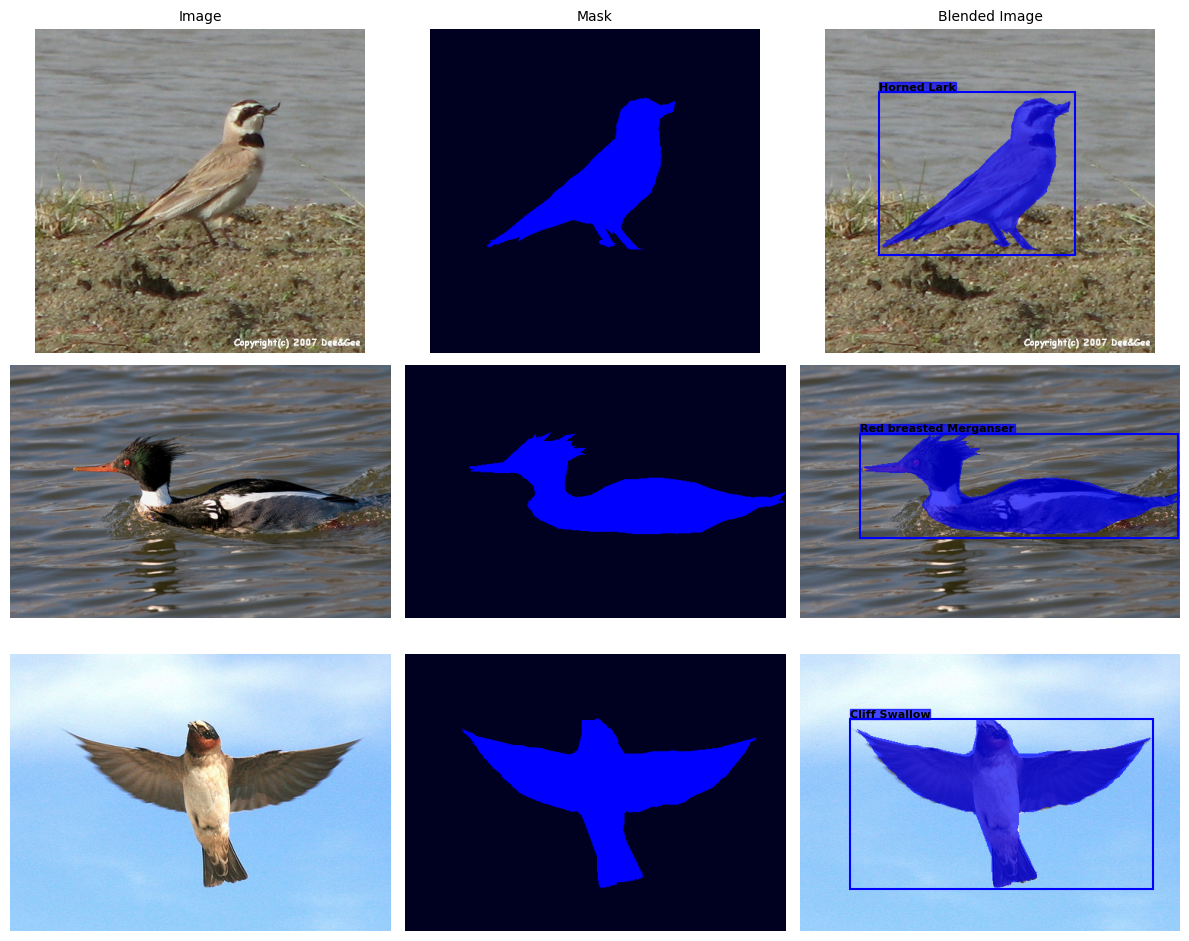

In [44]:
plot_image_masks(df_data)

## **eBird Dataset**

The eBird dataset is not available for direct download like the CUB-200-2011 dataset. Therefore, I created an account on the [official eBird website](https://ebird.org/explore), from which I downloaded the raw CSV file for the 200 species in the CUB-200-2011 dataset. I used the search function to enter each species' common or scientific name on the website and pressed the ``Export`` button to download the CSV, which I then saved to my personal Google Drive. These CSVs contain several columns with information about the birds, but unfortunately, they do not include a column for bounding boxes for object detection or masks for image segmentation, so they can only be used for image classification. In this case, we need the ``ML Catalog Number`` column, which contains the unique catalog number for each image required to download it via the eBird API, and the ``Format`` column to select only images and exclude videos or audios.

Once all the CSVs are saved, this notebook downloads all the images for the 200 bird classes using the catalog number of each image. This process takes approximately 1 hour and 20 minutes. Additionally, a Pandas DataFrame with the necessary metadata is created. Finally, the folder containing the images and the DataFrame is compressed into a ZIP file and saved to my personal Google Drive.

In [ ]:
# Parameters
path_raw_data = "/content/drive/MyDrive/Raw_eBird"
path_data = "/content/eBird"
path_data_zip = "/content/drive/MyDrive/Datasets/eBird.zip"

# Create the folder if it has not been created yet
os.makedirs(path_data, exist_ok=True)

In [ ]:
# View a raw CSV file for a bird species
df_example = pd.read_csv(os.path.join(path_raw_data, f"{class_names[0]}.csv"))
df_example.head(3)

,ML Catalog Number,Format,Common Name,Scientific Name,Background Species,Recordist,Date,Year,Month,Day,...,Parent Species,eBird Species Code,Taxon Category,Taxonomic Sort,Recordist 2,Average Community Rating,Number of Ratings,Asset Tags,Original Image Height,Original Image Width
0,328888881,Photo,Black-footed Albatross,Phoebastria nigripes,NaN,Mason Maron,2020-08-08,2020,8,8.0,...,Phoebastria nigripes,bkfalb,Species,6828,NaN,4.93,195,NaN,2307.0,3807.0
1,349422041,Photo,Black-footed Albatross,Phoebastria nigripes,NaN,Mason Maron,2021-06-19,2021,6,19.0,...,Phoebastria nigripes,bkfalb,Species,6828,NaN,4.94,106,NaN,2177.0,3871.0
2,621892751,Photo,Black-footed Albatross,Phoebastria nigripes,NaN,Mason Maron,2024-07-20,2024,7,20.0,...,Phoebastria nigripes,bkfalb,Species,6828,NaN,4.96,24,NaN,3263.0,4079.0


In [ ]:
# Download images of the 200 bird species
for name in tqdm(class_names):
  df = pd.read_csv(os.path.join(path_raw_data, f"{name}.csv"))
  df = df[df.Format == "Photo"]
  df = df.iloc[:100] #Select only the first 100 high-quality images

  folder = os.path.join(path_data, name)
  os.makedirs(folder, exist_ok=True)

  for cat_number in df["ML Catalog Number"].values:
    url = f"https://cdn.download.ams.birds.cornell.edu/api/v2/asset/{cat_number}/640"
    img_data = requests.get(url).content
    with open(os.path.join(folder, f"{cat_number}.jpg"), "wb") as handler:
      handler.write(img_data)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Create the DataFrame with the image paths and their respective labels
list_df = []
for id, name in enumerate(class_names):
  image_path = os.path.join(path_data, name)
  images = [os.path.join(image_path, path) for path in os.listdir(image_path)]

  df = pd.DataFrame({
      "image": images,
      "label": id
  })
  list_df.append(df)

df_data_ebird = pd.concat(list_df)
df_data_ebird = df_data_ebird.sample(frac=1, random_state=SEED).reset_index(drop=True)
df_data_ebird

,image,label
0,/content/eBird/Harris Sparrow/142721421.jpg,121
1,/content/eBird/Horned Lark/552207141.jpg,84
2,/content/eBird/White breasted Kingfisher/17160...,82
3,/content/eBird/Red eyed Vireo/619940576.jpg,153
4,/content/eBird/Seaside Sparrow/33372121.jpg,127
...,...,...
19990,/content/eBird/Gray Kingbird/503398551.jpg,77
19991,/content/eBird/Red eyed Vireo/546788781.jpg,153
19992,/content/eBird/Swainson Warbler/94109311.jpg,177
19993,/content/eBird/Bay breasted Warbler/450170681.jpg,157


In [ ]:
# There are no null values
df_data_ebird.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19995 entries, 0 to 19994
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   19995 non-null  object
 1   label   19995 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.5+ KB


The dataset is balanced with 100 images per class, except for class ``5``, which has 95 images. However, this difference is minimal, so the dataset can be considered balanced.

In [ ]:
df_data_ebird.label.value_counts().sort_values()

,count
label,
5,95
84,100
82,100
153,100
127,100
...,...
126,100
159,100
187,100


In [ ]:
# Save the preprocessed DataFrame in CSV format
df_data_ebird.to_csv(os.path.join(path_data, "metadata_ebird.csv"), index=False)

In [ ]:
# Compress the folder containing the dataset and metadata into a ZIP file and save it to the specified path
!zip -r $path_data_zip eBird -q